# Pycnocline depth and variance calculations comparisons in models and observations

** Summary: **
Compute pycnocline depth as first moment of temperature stratification. Compare timeseries and variance quantities between observations and different model configurations.

** Problems/To do **
* Should relabel 'temp_mod' to 'temp' since the obs data is also stored in this array
* Change ii and jj to iconf and iloc to better represent configuration and location indices.
* Move the calculation of delta to a function since it is called once for model profiles and once for obs. It is also used in other notebooks.

** Notebook: ** pycnocline_mod_obs_virtual_moorings.ipynb

** Author: ** jelt 7 Nov 2016

** Changelog: **
* 7 Nov 2016: get started from jelt script peanom.ipynb
* Move all function calls to unique copy in amm60_data_tools.py



$$\delta = H (T_b - T_{bar}) / (T_{top} - T_b)$$ is the expression used.
Where does this come from?

For a two layer fluid
$$T_{bar} = (h_{top} T_{top} + h_{bot} T_{bot})/H $$
Therefore
$$H T_{bar} = \delta T_{top} + (H-\delta) T_{bot} $$



$$ \delta = H (T_{bar} - T_{bot}) / (T_{top} - T_{bot} )   $$

In [11]:
from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from copy import deepcopy 

from amm60_data_tools import NEMO_fancy_datestr
from amm60_data_tools import doodsonX0
from amm60_data_tools import readMODELnc


%matplotlib inline

from __future__ import division

In [14]:
# Global constants
time_origin = '1950-01-01 00:00:00'
dstart = datetime.datetime(2012,6,10) # For plotting
dend = datetime.datetime(2012,7,3)

dirname = '/Users/jeff/GitHub/AMM60_paper/Programs/FASTNEt/' # Set path structure for files

locations = ['ST1','ST2','ST4','ST5','SE']
configurations = ['NNA','AMM60','AMM7','obs'] # Note the observational data is in each config file, except NNA
# The observational data is extracted from the last config file loaded

In [7]:
# Load the data and map each location to the axis 1 and config to axis 2
# e.g. temp_mod[time, location, config]
labels =   [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
temp_mod = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
temp_obs = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
delta    = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
delta_nt = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
internal_tide_map = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
internal_tide_map_3day = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
pycn_depth_map    = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
pycn_depth_map_3day    = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
depth        = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
time_str = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
time_counter = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
time_counter_3day = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
time_datetime = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
time_datetime_3day = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
print 'Really need a better way to define the "empty" variables...'


for jj in range(len(locations)):
    dz = []
    if (locations[jj] == 'SE'):
        max_depth = 100 # This is a fix for a bug in the moorings files not in the NEMO output
    else:
        max_depth = 150

    for ii in range(len(configurations)-1): # Exclude looping over 'obs' since these data are not in a separate file but embedded in model files.
        path = dirname+'Moorings_'+configurations[ii]+'/' 
        filename = path+'mooring_'+locations[jj]+'.nc'

        labels[jj][ii] = str(locations[jj])+'_'+str(configurations[ii])

        depth[jj][ii] = readMODELnc(filename,'depth')
        time_counter[jj][ii] = readMODELnc(filename,'time')
#        temp_obs[jj][ii] = readMODELnc(filename,'temp_obs')
        temp_mod[jj][ii] = readMODELnc(filename,'temp_mod')

        # Compute thermocline depth as first moment of stratification
        [nz,nt] = np.shape(temp_mod[jj][ii]) # temp_mod and temp_obs are same size
#        print 'size of temp_mod', [nz,nt]
#        print 'size of temp_obs', np.shape(temp_obs[jj][ii])


        # Find the index for the shallowest of 200m or bed
        index_bed = np.sum(np.isfinite(temp_mod[jj][ii]), axis = 0, dtype='int')-1 # Sum over depth. Returns number of finite levels per timestep
        index_200m = np.tile(np.argmin( abs(depth[jj][ii] - max_depth)), nt)
        index = [ min([nz-2, index_200m[k], index_bed[k]]) for k in range(nt)] # nz-2 avoids dz being computed with levels that don't exist
        temp_bot = np.zeros(nt) # the temperature at min(depth,200m)
        temp_bot[:] = [temp_mod[jj][ii][index[mm], mm] for mm in range(nt)]
        
        dz = np.zeros((nz,nt))
        temp_bar = np.zeros((nt))
        for m in range(nt):
#            for k in range(index[m]+1):
#                dz[k,m] = depth[jj][ii][k+1] - depth[jj][ii][k] # depth and dz are POSITIVE. k=0 is surface layer
            for k in range(index[m]):
                dz[k+1,m] = depth[jj][ii][k+1] - depth[jj][ii][k] # depth and dz are POSITIVE. k=0 is surface layer                
            temp_bar[m] = np.nansum( dz[:,m] * temp_mod[jj][ii][:,m] ) / ( depth[jj][ii][index[m]] )
            
        temp_top = np.zeros(nt)
        temp_top[:] = temp_mod[jj][ii][0, :]
            
        delta[jj][ii] = depth[jj][ii][index] * (temp_bot - temp_bar) / (temp_top - temp_bot)
        delta[jj][ii] = -np.tile(delta[jj][ii], (1,1,1)).T # DoodsonX0 expects a (time, y, x) array 
        
        [time_str[jj][ii],time_datetime[jj][ii], flag_err] = NEMO_fancy_datestr( np.array(time_counter[jj][ii][:]*24*3600, dtype='int'),time_origin ) # internal tide data



        
        # Add diagnostics for the observational data. ii=3. These are reproduced in each model config run but only populate variable for config ii=2
        if (configurations[ii] == 'AMM7'): 
            ii_obs = configurations.index("obs")
            labels[jj][ii_obs] = str(locations[jj])+'_'+'obs'
            temp_mod[jj][ii_obs] = readMODELnc(filename,'temp_obs')
            depth[jj][ii_obs] = readMODELnc(filename,'depth')
            time_counter[jj][ii_obs] = deepcopy(time_counter[jj][ii])
            time_datetime[jj][ii_obs] = deepcopy(time_datetime[jj][ii])


            # Compute thermocline depth as first moment of stratification
            [nz,nt] = np.shape(temp_mod[jj][ii_obs]) # temp_mod and temp_obs are same size
              
            # Find the index for the shallowest of 200m or bed
            index_bed = np.sum(np.isfinite(temp_mod[jj][ii_obs]), axis = 0, dtype='int')-1 # Sum over depth. Returns number of finite levels per timestep
            index_200m = np.tile(np.argmin( abs(depth[jj][ii_obs] - max_depth)), nt)
            index = [ min([nz-2, index_200m[k], index_bed[k]]) for k in range(nt)] # nz-2 avoids dz being computed with levels that don't exist
            temp_bot = np.zeros(nt) # the temperature at min(depth,200m)
            temp_bot[:] = [temp_mod[jj][ii_obs][index[mm], mm] for mm in range(nt)]

            dz = np.zeros((nz,nt))
            temp_bar = np.zeros((nt))
            for m in range(nt):

                for k in range(index[m]):
                    dz[k+1,m] = depth[jj][ii][k+1] - depth[jj][ii][k] # depth and dz are POSITIVE. k=0 is surface layer                
#               for k in range(index[m]+1):
#                    tt = 6
#                    dz[k,m] = depth[jj][ii_obs][k+1] - depth[jj][ii_obs][k] # depth and dz are POSITIVE. k=0 is surface layer
                temp_bar[m] = np.nansum( dz[:,m] * temp_mod[jj][ii_obs][:,m] ) / ( depth[jj][ii_obs][index[m]] )

            temp_top = np.zeros(nt)
            temp_top[:] = temp_mod[jj][ii_obs][0, :]

            delta[jj][ii_obs] = depth[jj][ii_obs][index] * (temp_bot - temp_bar) / (temp_top - temp_bot)
            delta[jj][ii_obs] = -np.tile(delta[jj][ii_obs], (1,1,1)).T # DoodsonX0 expects a (time, y, x) array 

            

for jj in range(len(locations)):
    for ii in range(len(configurations)): # Exclude looping over 'obs' since these data are not in a separate file but embedded in model files.
        
        # Tidally filter pycnocline depth with Doodson filter
        ################################
        # Tile the delta to increase the timeseries length if it is less than the Doodson filter length.
        if np.shape(delta[jj][ii])[0] < 19*2+1:
            delta[jj][ii] = np.tile(delta[jj][ii], (2,1,1));
            print 'time series too short to do Doodson filter - tiled in time'

        ## Apply DoodsonX0 filter
        # For this function the time is assumed to be hourly
        delta_nt[jj][ii] = doodsonX0(time_counter[jj][ii],delta[jj][ii]);
        #print 'Doodson filter for '+labels[jj][ii]

        ## Define the internal tide variance
        ################################
        internal_tide_map[jj][ii] = np.nanvar(delta[jj][ii] - delta_nt[jj][ii], axis = 0)
        ## Define the pycnocline depth
        pycn_depth_map[jj][ii] = np.nanmean(abs(delta_nt[jj][ii]), axis = 0)


        ## Define the internal tide variance in 3 day chunks
        ####################################################
        [nz,nt] = np.shape(temp_mod[jj][ii]) # temp_mod and temp_obs are same size
        i = 0
        internal_tide_map_3day[jj][ii] = np.zeros((int(nt/(24*3)), 1,1))
        pycn_depth_map_3day[jj][ii]    = np.zeros((int(nt/(24*3)), 1,1))
        time_counter_3day[jj][ii]      = np.zeros((int(nt/(24*3)), 3*24))
        time_datetime_3day[jj][ii]  = np.array([datetime.datetime(1900,1,1) for loop in xrange(int(nt/(24*3)))]) # dummy datetime array
        #print time_datetime_3day[jj][ii]
        while ((3*i+3)*24 <= nt): 
                internal_tide_map_3day[jj][ii][i,:,:] = np.nanvar(delta[jj][ii][3*i*24:(3*i+3)*24,:,:]  - delta_nt[jj][ii][3*i*24:(3*i+3)*24,:,:], axis = 0)
                pycn_depth_map_3day[jj][ii][i,:,:]    = np.nanmean( abs(delta_nt[jj][ii][3*i*24:(3*i+3)*24,:,:]), axis = 0)
                time_counter_3day[jj][ii][i,:] = time_counter[jj][ii][3*i*24:(3*i+3)*24]
                time_datetime_3day[jj][ii][i] = time_datetime[jj][ii][int(3*i*24 + 3*24 // 2)] # store middle times
                #print time_datetime[jj][ii][int(3*i*24 + 3*12)]
                #print time_datetime_3day[jj][ii][i]
                i += 1
#                print 'Chunking pycnocline data: ',i,' of ',int(nt/(24*3)),'. [jj,ii,nt]=',int(jj),int(ii),int(nt)

        print 'Chunking done for ',labels[jj][ii],' :[jj,ii]=',int(jj),int(ii)

Really need a better way to define the "empty" variables...
Chunking done for  ST1_NNA  :[jj,ii]= 0 0
Chunking done for  ST1_AMM60  :[jj,ii]= 0 1
Chunking done for  ST1_AMM7  :[jj,ii]= 0 2
Chunking done for  ST1_obs  :[jj,ii]= 0 3
Chunking done for  ST2_NNA  :[jj,ii]= 1 0
Chunking done for  ST2_AMM60  :[jj,ii]= 1 1
Chunking done for  ST2_AMM7  :[jj,ii]= 1 2
Chunking done for  ST2_obs  :[jj,ii]= 1 3
Chunking done for  ST4_NNA  :[jj,ii]= 2 0
Chunking done for  ST4_AMM60  :[jj,ii]= 2 1
Chunking done for  ST4_AMM7  :[jj,ii]= 2 2
Chunking done for  ST4_obs  :[jj,ii]= 2 3
Chunking done for  ST5_NNA  :[jj,ii]= 3 0
Chunking done for  ST5_AMM60  :[jj,ii]= 3 1
Chunking done for  ST5_AMM7  :[jj,ii]= 3 2
Chunking done for  ST5_obs  :[jj,ii]= 3 3
Chunking done for  SE_NNA  :[jj,ii]= 4 0
Chunking done for  SE_AMM60  :[jj,ii]= 4 1
Chunking done for  SE_AMM7  :[jj,ii]= 4 2
Chunking done for  SE_obs  :[jj,ii]= 4 3


In [16]:
print locations

['ST1', 'ST2', 'ST4', 'ST5', 'SE']


['SE_NNA', 'SE_AMM60', 'SE_AMM7', 'SE_obs']


/Users/jeff/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


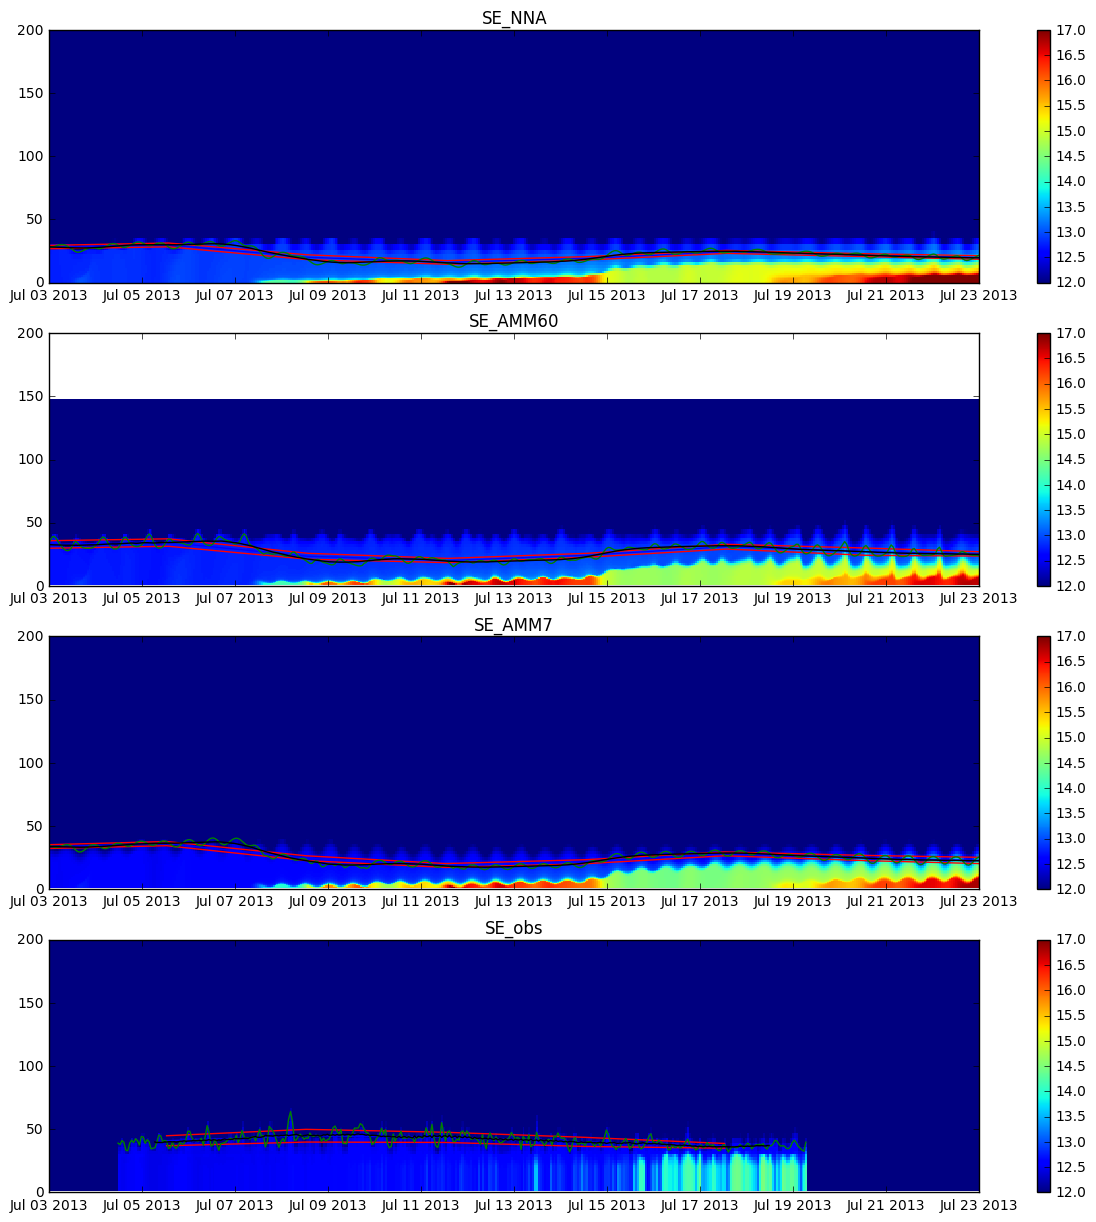

In [8]:
# Plot Configurations at fixed location
jj = 4
print labels[jj][:]
fig, ax = plt.subplots(4,1)
plt.rcParams['figure.figsize'] = (15.0, 15.0) 
for ii in range(len(labels[0])):
    plt.subplot(4,1,ii+1)
    plt.pcolormesh(time_datetime[jj][ii],depth[jj][ii],temp_mod[jj][ii])
    plt.clim([5.5,15.5])
    plt.ylim([0, 200])
    if (locations[jj] == 'SE'):
        plt.xlim([datetime.datetime(2013,7,3),datetime.datetime(2013,7,23)])
    else:
        plt.xlim([dstart,dend])
    plt.clim([12,17])
    plt.title(labels[jj][ii])
    plt.colorbar()
    
    plt.plot(time_datetime_3day[jj][ii],pycn_depth_map_3day[jj][ii][:,0,0],'b-')
    plt.plot(time_datetime_3day[jj][ii],pycn_depth_map_3day[jj][ii][:,0,0]+np.sqrt(internal_tide_map_3day[jj][ii][:,0,0]),'r-')
    plt.plot(time_datetime_3day[jj][ii],pycn_depth_map_3day[jj][ii][:,0,0]-np.sqrt(internal_tide_map_3day[jj][ii][:,0,0]),'r-')
    plt.plot(time_datetime[jj][ii], delta[jj][ii][:,0,0], 'g')
    plt.plot(time_datetime[jj][ii], delta_nt[jj][ii][:,0,0], 'k')    
    

In [18]:
print configurations

['NNA', 'AMM60', 'AMM7', 'obs']


['ST1_NNA', 'ST2_NNA', 'ST4_NNA', 'ST5_NNA', 'SE_NNA']


IndexError: too many indices for array

/Users/jeff/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


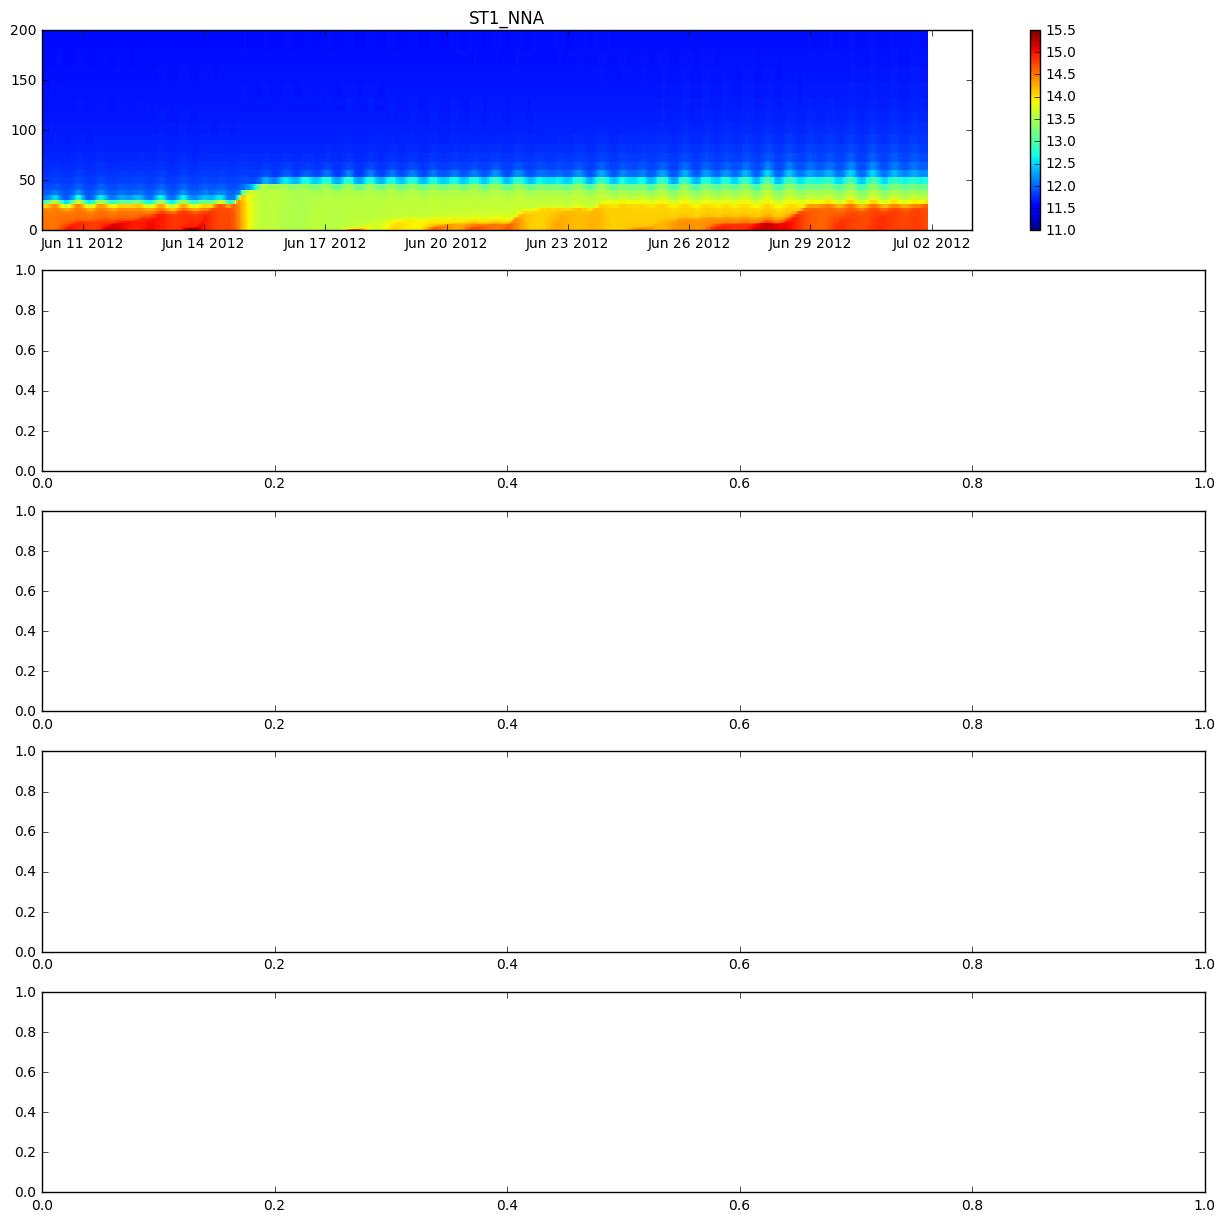

In [10]:
# Plot locations for fixed configurations
ii = 0
print([labels[kk][ii] for kk in range(len(locations))])

fig, ax = plt.subplots(len(locations),1)
plt.rcParams['figure.figsize'] = (15.0, 15.0) 
for jj in range(len(locations)):
    plt.subplot(len(locations),1,jj+1)
    plt.pcolormesh(time_datetime[jj][ii],depth[jj][ii],temp_mod[jj][ii])
    plt.clim([11,15.5])
    plt.title(labels[jj][ii])
    if (locations[jj] == 'SE'):
        plt.xlim([datetime.datetime(2013,7,3),datetime.datetime(2013,7,23)])
    else:
        plt.xlim([dstart,dend])
    plt.ylim([0, 200])
    plt.colorbar()
    
    plt.plot(time_datetime_3day[jj][ii],pycn_depth_map_3day[jj][ii][:,0,0],'b-')
    plt.plot(time_datetime_3day[jj][ii],pycn_depth_map_3day[jj][ii][:,0,0]+np.sqrt(internal_tide_map_3day[jj][ii][:,0,0]),'r-')
    plt.plot(time_datetime_3day[jj][ii],pycn_depth_map_3day[jj][ii][:,0,0]-np.sqrt(internal_tide_map_3day[jj][ii][:,0,0]),'r-')
    plt.plot(time_datetime[jj][ii], delta[jj][ii][:,0,0], 'g')
    plt.plot(time_datetime[jj][ii], delta_nt[jj][ii][:,0,0], 'k')



In [9]:
print np.shape(pycn_depth_map_3day[1][3])
print np.shape(time_datetime_3day[1][3])
print labels
print jj, ii

(10,)
()
[['ST1_NNA', 'ST1_AMM60', 'ST1_AMM7', 'ST1_obs'], ['ST2_NNA', 'ST2_AMM60', 'ST2_AMM7', 'ST2_obs'], ['ST4_NNA', 'ST4_AMM60', 'ST4_AMM7', 'ST4_obs'], ['ST5_NNA', 'ST5_AMM60', 'ST5_AMM7', 'ST5_obs'], ['SE_NNA', 'SE_AMM60', 'SE_AMM7', 'SE_obs']]
0 3


ValueError: x and y must have same first dimension

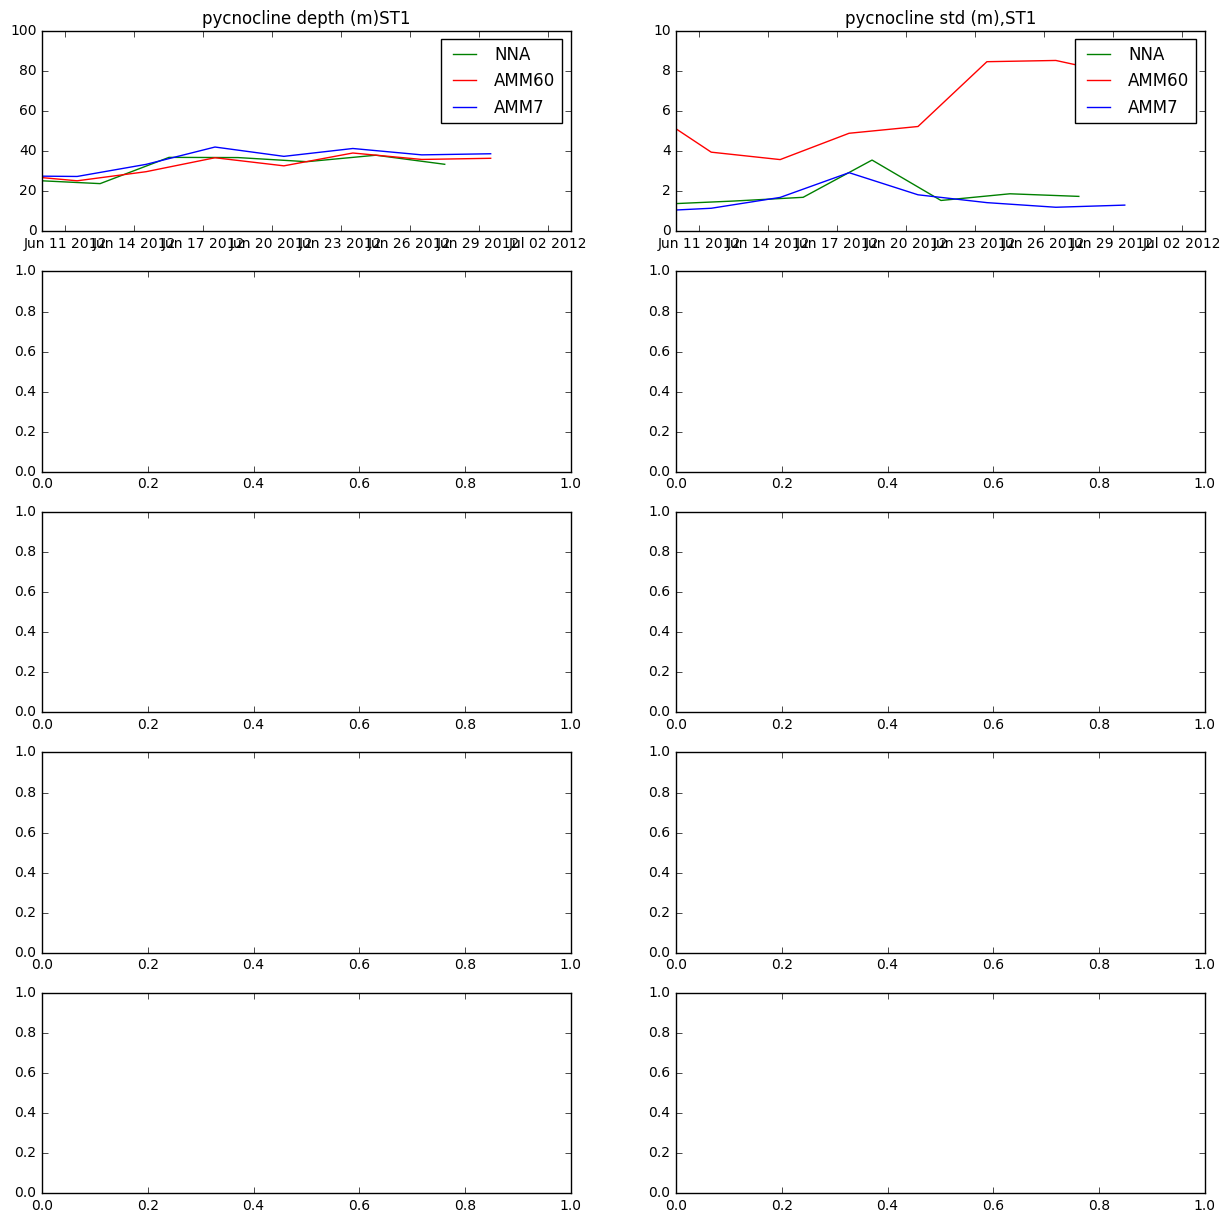

In [8]:
# Plot pyncocline depth and variance for each configuration at each location
#ii = 3
#print([labels[kk][ii] for kk in range(len(locations))])

col_list = ['green','red','blue','black']
fig, ax = plt.subplots(len(locations),2)
plt.rcParams['figure.figsize'] = (15.0, 15.0) 
#for jj in range(1):
for jj in range(len(locations)):
    for ii in range(len(configurations)):
        # Pycnocline depth
        plt.subplot(len(locations),2,2*jj+1)    
        plt.plot(time_datetime_3day[jj][ii],pycn_depth_map_3day[jj][ii][:],color=col_list[ii],label=labels[jj][ii])
#        plt.plot(time_datetime_3day[jj][ii],pycn_depth_map_3day[jj][ii][:,0,0],color=col_list[ii],label=labels[jj][ii])
    #    plt.plot(time_datetime_3day[jj][ii],pycn_depth_map_3day[jj][ii][:,0,0]+np.sqrt(internal_tide_map_3day[jj][ii][:,0,0]),'r-')
    #    plt.plot(time_datetime_3day[jj][ii],pycn_depth_map_3day[jj][ii][:,0,0]-np.sqrt(internal_tide_map_3day[jj][ii][:,0,0]),'r-')
    #    plt.plot(time_datetime[jj][ii], delta[jj][ii][:,0,0], 'g')
    #    plt.plot(time_datetime[jj][ii], delta_nt[jj][ii][:,0,0], 'k')   
        plt.title('pycnocline depth (m)'+locations[jj])
        if (locations[jj] == 'SE'):
            plt.xlim([datetime.datetime(2013,7,3),datetime.datetime(2013,7,23)])
        else:
            plt.xlim([dstart,dend])
        plt.ylim([0, 100])
        plt.legend(configurations)
        
        # Pycnocline depth sqrt(variance)
        plt.subplot(len(locations),2,2*jj+2)    
        plt.plot(time_datetime_3day[jj][ii],np.sqrt(internal_tide_map_3day[jj][ii][:]),color=col_list[ii])
#        plt.plot(time_datetime_3day[jj][ii],np.sqrt(internal_tide_map_3day[jj][ii][:,0,0]),color=col_list[ii])
    #    plt.plot(time_datetime_3day[jj][ii],pycn_depth_map_3day[jj][ii][:,0,0]+np.sqrt(internal_tide_map_3day[jj][ii][:,0,0]),'r-')
    #    plt.plot(time_datetime_3day[jj][ii],pycn_depth_map_3day[jj][ii][:,0,0]-np.sqrt(internal_tide_map_3day[jj][ii][:,0,0]),'r-')
    #    plt.plot(time_datetime[jj][ii], delta[jj][ii][:,0,0], 'g')
    #    plt.plot(time_datetime[jj][ii], delta_nt[jj][ii][:,0,0], 'k')   
        plt.title('pycnocline std (m),'+locations[jj])
        if (locations[jj] == 'SE'):
            plt.xlim([datetime.datetime(2013,7,3),datetime.datetime(2013,7,23)])
        else:
            plt.xlim([dstart,dend])
        plt.ylim([0, 10])
        plt.legend(configurations)







Pycnocline depth:

* SE:

All the models simulated a surface warming that did not appear in the observations. Hence the pycnocline depth differences.

* Others:

Haven't checked but I would expect a shallower pycnocline to be explainable in terms of lack of sharpness or something.

Pycnocline std=sqrt(variance): This has units of metres. (I previously have talked about variance when I guess I really should sqrt --> standard deviation, so that it has units of metres)

Near the shelf break (ST1, ST2) the std is well represented in AMM60.
Onshelf AMM60 best captures the observed variance.

# NEW ATTEMPT TO PROCESS DATA

In [1]:
from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from copy import deepcopy 
#import AMM60_tools
from amm60_data_tools import NEMO_fancy_datestr
from amm60_data_tools import doodsonX0
from amm60_data_tools import delta_diagnose
from amm60_data_tools import readMODELnc
%matplotlib inline

from __future__ import division

/Users/jeff/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Global constants
time_origin = '1950-01-01 00:00:00'
dstart = datetime.datetime(2012,6,10) # For plotting
dend = datetime.datetime(2012,7,3)

dirname = '/Users/jeff/GitHub/AMM60_paper/Programs/FASTNEt/' # Set path structure for files

locations = ['ST1','ST2','ST4','ST5','SE']
configurations = ['NNA','AMM60','AMM7','obs'] # Note the observational data is in each config file, except NNA
# The observational data is extracted from the last config file loaded

In [3]:
# Load the data and map each location to the axis 1 and config to axis 2
# e.g. temp_mod[time, location, config]
labels =   [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
temp_mod = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
temp_obs = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
delta    = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
delta_nt = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
internal_tide_map = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
internal_tide_map_3day = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
pycn_depth_map    = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
pycn_depth_map_3day    = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
depth        = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
time_str = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
time_counter = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
time_counter_3day = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
time_datetime = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
time_datetime_3day = [['c1','c2','c3','obs'], ['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'],['c1','c2','c3','obs'] ]
print 'Really need a better way to define the "empty" variables...'


for jj in range(len(locations)):
    dz = []
    if (locations[jj] == 'SE'):
        max_depth = 100 # This is a fix for a bug in the moorings files not in the NEMO output
    else:
        max_depth = 150

    for ii in range(len(configurations)-1): # Exclude looping over 'obs' since these data are not in a separate file but embedded in model files.
        path = dirname+'Moorings_'+configurations[ii]+'/' 
        filename = path+'mooring_'+locations[jj]+'.nc'

        labels[jj][ii] = str(locations[jj])+'_'+str(configurations[ii])

        depth[jj][ii] = readMODELnc(filename,'depth')
        time_counter[jj][ii] = readMODELnc(filename,'time')*24*3600
#        temp_obs[jj][ii] = readMODELnc(filename,'temp_obs')
        temp_mod[jj][ii] = readMODELnc(filename,'temp_mod')

    
    
        [delta[jj][ii], delta_nt[jj][ii], internal_tide_map[jj][ii], time_datetime[jj][ii],  pycn_depth_map_3day[jj][ii], internal_tide_map_3day[jj][ii], time_datetime_3day[jj][ii]] = delta_diagnose( temp_mod[jj][ii], time_counter[jj][ii], depth[jj][ii], max_depth )


        
        # Add diagnostics for the observational data. ii=3. These are reproduced in each model config run but only populate variable for config ii=2
        if (configurations[ii] == 'AMM7'): 
            ii_obs = configurations.index("obs")
            labels[jj][ii_obs] = str(locations[jj])+'_'+'obs'
            temp_mod[jj][ii_obs] = readMODELnc(filename,'temp_obs')
            depth[jj][ii_obs] = readMODELnc(filename,'depth')
            time_counter[jj][ii_obs] = deepcopy(time_counter[jj][ii])
            #time_datetime[jj][ii_obs] = deepcopy(time_datetime[jj][ii])


            
            
            [delta[jj][ii_obs], delta_nt[jj][ii_obs], internal_tide_map[jj][ii_obs], time_datetime[jj][ii_obs],  pycn_depth_map_3day[jj][ii_obs], internal_tide_map_3day[jj][ii_obs], time_datetime_3day[jj][ii]] = delta_diagnose( temp_mod[jj][ii_obs], time_counter[jj][ii_obs], depth[jj][ii_obs], max_depth )


            
    

Really need a better way to define the "empty" variables...
Chunking done.
Chunking done.


/Users/jeff/anaconda/lib/python2.7/site-packages/scipy/io/netcdf.py:297: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


Chunking done.
Chunking done.
Chunking done.
Chunking done.


/Users/jeff/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/Users/jeff/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Chunking done.
Chunking done.
Chunking done.
Chunking done.
Chunking done.
Chunking done.
Chunking done.
Chunking done.
Chunking done.
Chunking done.
Chunking done.
Chunking done.
Chunking done.
Chunking done.


# Now call one of the three plotting cells above